<a href="https://colab.research.google.com/github/matdcp/Data-dreamers-/blob/main/NEURAL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Upload data


In [1]:
from google.colab import files
uploaded = files.upload()

Saving file1.ann to file1.ann
Saving file2.ann to file2.ann


In [2]:
import csv
import pandas as pd

# Funzione per convertire un file .ann in .csv
def convert_ann_to_csv(input_file, output_file):
    data = []
    with open(input_file, 'r', encoding='utf-8') as f:
        for line in f:
            line = line.strip()  # Rimuovi spazi vuoti
            if line and '\t' in line:  # Controlla che non sia vuota e contenga tabulazioni
                parts = line.split('\t')
                if len(parts) == 4:  # Controlla che ci siano esattamente 4 colonne
                    id, start, end, label = parts
                    # Filtra token non alfanumerici o righe non valide
                    if id.isalnum() or len(id) > 1:  # Mantieni token validi
                        try:
                            # Prova a convertire start e end in interi
                            data.append([id, int(start), int(end), label])
                        except ValueError:
                            continue

    # Scrivi il file CSV
    with open(output_file, 'w', encoding='utf-8', newline='') as f:
        writer = csv.writer(f)
        writer.writerow(['id', 'Start', 'End', 'Label'])  # Intestazioni
        writer.writerows(data)

# Percorsi dei file .ann
file1_ann_path = 'file1.ann'  # Sostituisci con il percorso reale
file2_ann_path = 'file2.ann'  # Sostituisci con il percorso reale

# Percorsi dei file CSV temporanei
file1_csv_path = 'file1_converted.csv'
file2_csv_path = 'file2_converted.csv'

# Conversione dei file .ann in .csv
convert_ann_to_csv(file1_ann_path, file1_csv_path)
convert_ann_to_csv(file2_ann_path, file2_csv_path)

# Caricamento dei file CSV convertiti in DataFrame
df1 = pd.read_csv(file1_csv_path)
df2 = pd.read_csv(file2_csv_path)

# Unione dei DataFrame
ds = pd.concat([df1, df2], ignore_index=True)

# Salvataggio del dataset unito come CSV
merged_dataset_path = 'merged_dataset.csv'
ds.to_csv(merged_dataset_path, index=False)

# Visualizzazione del risultato
print(f"Dataset unito salvato come '{merged_dataset_path}'")
print(ds.head())



Dataset unito salvato come 'merged_dataset.csv'
             id  Start  End                     Label
0   Ventricular      0   11  B-Multi-tissue_structure
1  fibrillation     12   24                         O
2           due     25   28                         O
3            to     29   31                         O
4          long     32   36                         O


In [3]:
# Caricamento del dataset
ds = pd.read_csv('merged_dataset.csv')

# Aggiungi una colonna per la lunghezza dei token (gestendo valori non stringa)
ds['id'] = ds['id'].astype(str)  # Converti tutti i valori in stringa
ds['token_length'] = ds['id'].apply(len)  # Calcola la lunghezza

# Filtra i token troppo lunghi (es. > 45 caratteri) o non alfanumerici
ds_cleaned = ds[(ds['token_length'] <= 45) & (ds['id'].str.isalnum())]

# Reimposta l'indice del dataset pulito
ds_cleaned.reset_index(drop=True, inplace=True)

# Salva il dataset pulito come CSV
ds_cleaned.to_csv('cleaned_dataset.csv', index=False)
print("Dataset pulito salvato come 'cleaned_dataset.csv'")
print(ds_cleaned.head())

Dataset pulito salvato come 'cleaned_dataset.csv'
             id  Start  End                     Label  token_length
0   Ventricular      0   11  B-Multi-tissue_structure            11
1  fibrillation     12   24                         O            12
2           due     25   28                         O             3
3            to     29   31                         O             2
4          long     32   36                         O             4


#MODEL

In [4]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout


In [5]:
# Carica il dataset pulito
data = pd.read_csv('cleaned_dataset.csv')

# Encoding delle etichette (y)
label_encoder = LabelEncoder()
data['Label'] = label_encoder.fit_transform(data['Label'])

# Feature (X) e target (y)
X = data[['token_length', 'Start', 'End']].values  # Modifica in base alle colonne rilevanti
y = data['Label'].values

# Dividi in train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [9]:
# Crea un modello di rete neurale feedforward
model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(len(np.unique(y)), activation='softmax')  # Numero di classi nell'output
])

# Compila il modello
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Addestra il modello
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.2)


Epoch 1/20
1926/1926 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.8355 - loss: 43.5590 - val_accuracy: 0.9537 - val_loss: 0.7492
Epoch 2/20
1926/1926 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.9515 - loss: 0.6844 - val_accuracy: 0.9537 - val_loss: 0.3466
Epoch 3/20
1926/1926 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.9520 - loss: 0.3610 - val_accuracy: 0.9537 - val_loss: 0.3160
Epoch 4/20
1926/1926 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.9514 - loss: 0.3288 - val_accuracy: 0.9537 - val_loss: 0.3111
Epoch 5/20
1926/1926 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.9514 - loss: 0.3289 - val_accuracy: 0.9537 - val_loss: 0.3096
Epoch 6/20
1926/1926 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9528 - loss: 0.3174 - val_accuracy: 0.9537 - val_loss: 0.3091
Epoch 7/20
1926/1926 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9506 - loss: 0.3290 - val_accuracy: 0.9537 - val_loss: 0.3088
Epoch 8/20
1926/1926 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.9521 - loss: 0.3203 -

In [7]:
# Valutazione sui dati di test
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Loss sul test: {test_loss}, Accuracy sul test: {test_accuracy}")


602/602 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9548 - loss: 0.3033
Loss sul test: 0.3038638234138489, Accuracy sul test: 0.9548216462135315


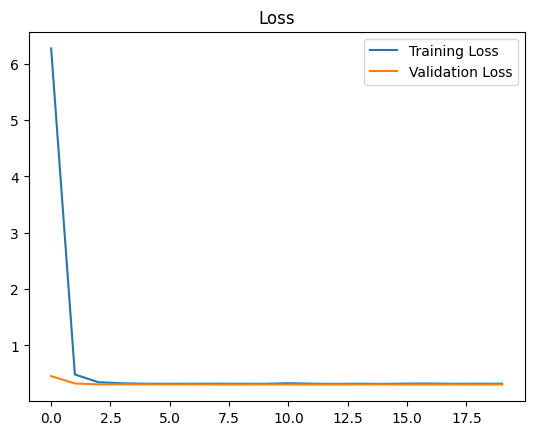

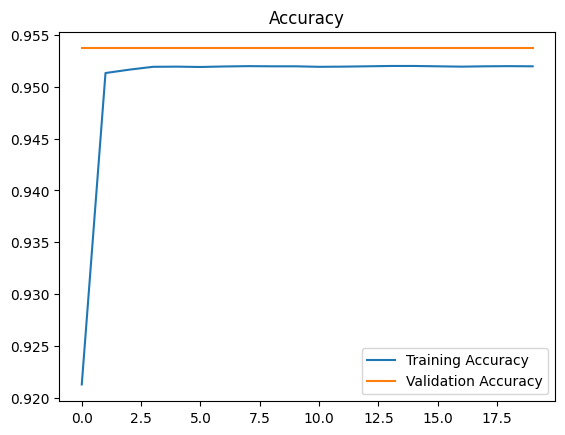

In [8]:
import matplotlib.pyplot as plt

# Loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss')
plt.show()

# Accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy')
plt.show()
